# E-commerce Product Delivery Prediction
Develop robust machine learning models to accurately predict product delivery timeliness. By utilizing these models, the company aims to improve customer satisfaction, optimize logistics, and gain insights into factors affecting delivery performance.

# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load the Data

In [ ]:
# Load data
df = pd.read_csv('E_Commerce.csv')

In [ ]:
df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


# Data preprocessing

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


In [ ]:
df.isnull().sum()

,0
ID,0
Warehouse_block,0
Mode_of_Shipment,0
Customer_care_calls,0
Customer_rating,0
Cost_of_the_Product,0
Prior_purchases,0
Product_importance,0
Gender,0
Discount_offered,0


In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df.describe()

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
count,10999.00000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,5500.00000,4.054459,2.990545,210.196836,3.567597,13.373216,3634.016729,0.596691
std,3175.28214,1.141490,1.413603,48.063272,1.522860,16.205527,1635.377251,0.490584
min,1.00000,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,0.000000
25%,2750.50000,3.000000,2.000000,169.000000,3.000000,4.000000,1839.500000,0.000000
50%,5500.00000,4.000000,3.000000,214.000000,3.000000,7.000000,4149.000000,1.000000
75%,8249.50000,5.000000,4.000000,251.000000,4.000000,10.000000,5050.000000,1.000000
max,10999.00000,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000,1.000000


In [ ]:
df = df.drop('ID', axis=1)

# EDA

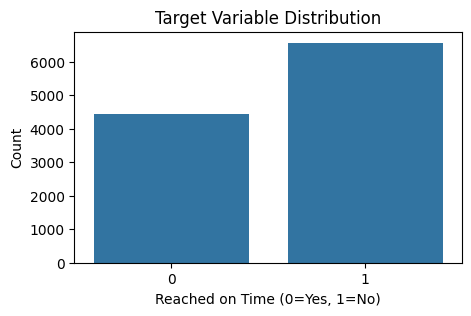

In [ ]:
# Target variable distribution
plt.figure(figsize=(5,3))
sns.countplot(x='Reached.on.Time_Y.N', data=df)
plt.title('Target Variable Distribution')
plt.xlabel('Reached on Time (0=Yes, 1=No)')
plt.ylabel('Count')
plt.show()

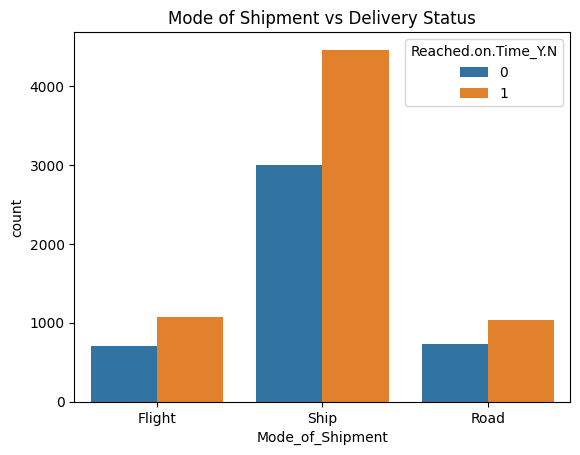

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Countplot for categorical features
sns.countplot(x='Mode_of_Shipment', hue='Reached.on.Time_Y.N', data=df)
plt.title('Mode of Shipment vs Delivery Status')
plt.show()

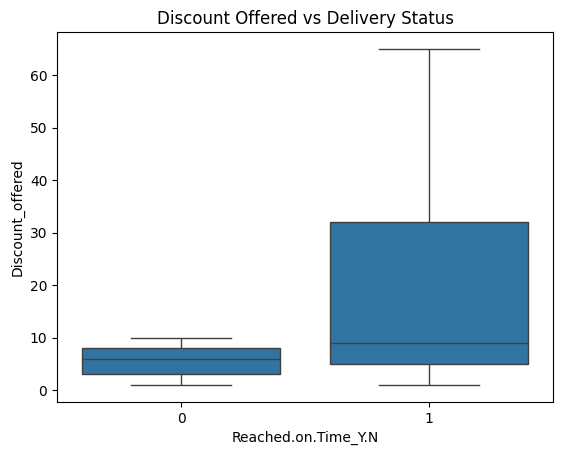

In [ ]:
# Boxplot for numerical features
sns.boxplot(x='Reached.on.Time_Y.N', y='Discount_offered', data=df)
plt.title('Discount Offered vs Delivery Status')
plt.show()

# Detecting Outlier

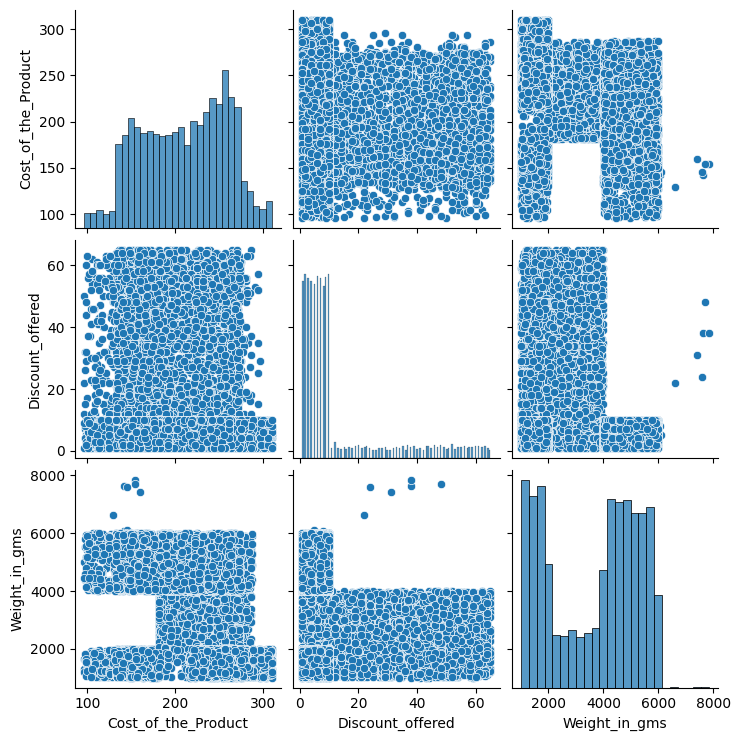

In [ ]:
# Outlier Detection
plot = ['Cost_of_the_Product', 'Discount_offered', 'Weight_in_gms']
sns.pairplot(df[plot])
plt.show()

It can be seen that there are several outliers in the 'Weight_in_gms' column so the outliers will be removed using IQR

In [ ]:
# Remove Outliers
Q1 = df['Weight_in_gms'].quantile(0.25)
Q3 = df['Weight_in_gms'].quantile(0.75)
IQR = Q3 - Q1


lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['Weight_in_gms'] >= lower_bound) & (df['Weight_in_gms'] <= upper_bound)]

# Does the weight of the product affect the delivery time?

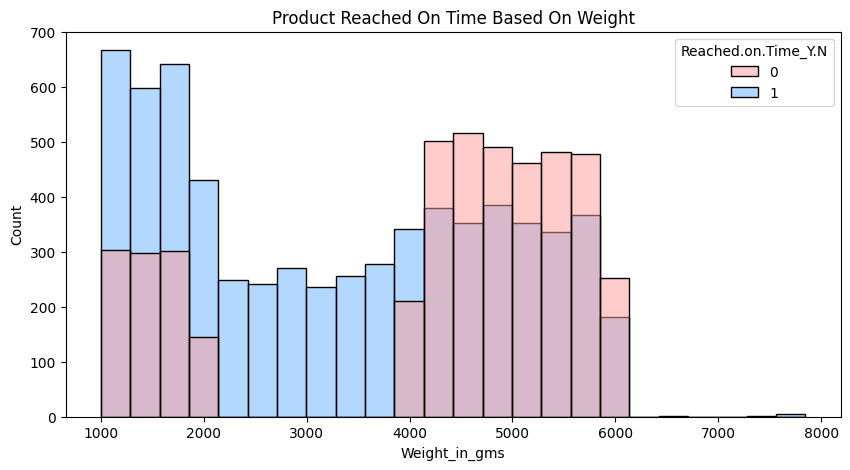

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='Weight_in_gms', hue='Reached.on.Time_Y.N', palette=['#ff9999', '#66b3ff'])
plt.title('Product Reached On Time Based On Weight')
plt.show()

# Is there a correlation between the cost of the product and the delivery time?

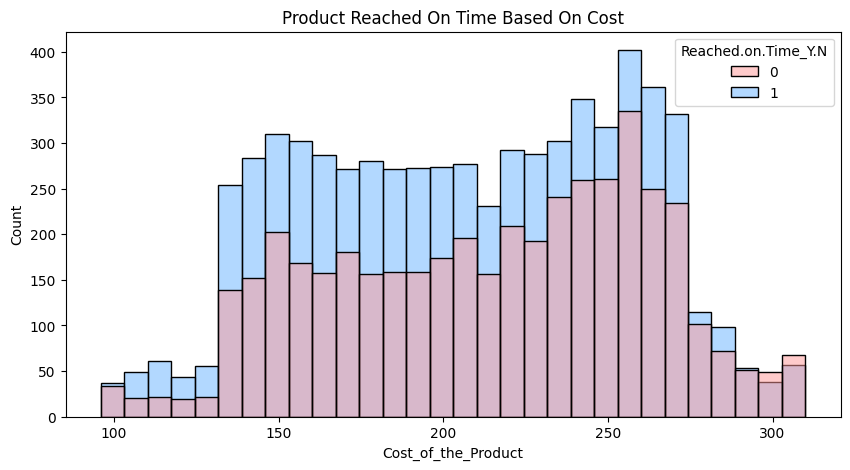

In [ ]:
plt.figure(figsize=(10, 5))
ax = sns.histplot(data=df, x='Cost_of_the_Product', hue='Reached.on.Time_Y.N', palette=['#ff9999', '#66b3ff'])

plt.title('Product Reached On Time Based On Cost')
plt.show()

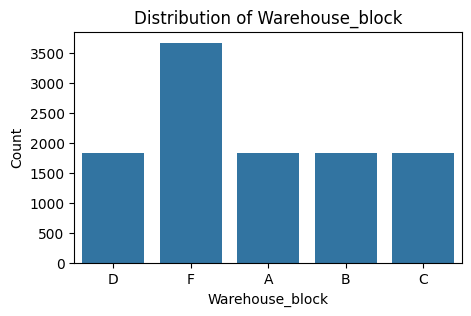

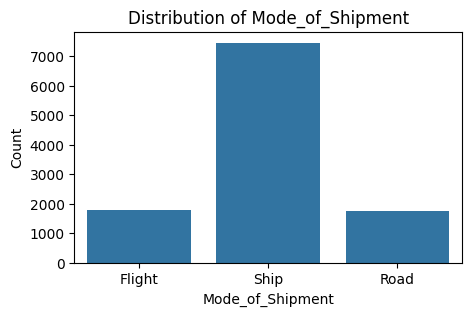

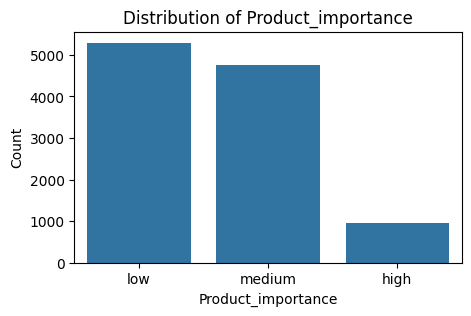

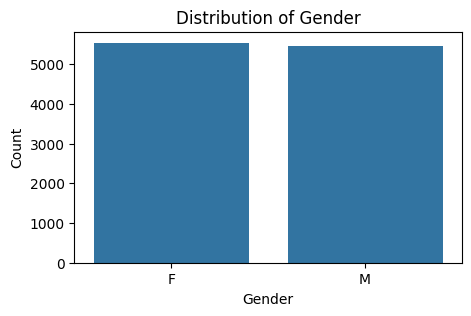

In [ ]:
# Categorical features distribution
categorical_cols = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']
for col in categorical_cols:
    plt.figure(figsize=(5,3))
    sns.countplot(x=col, data=df)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

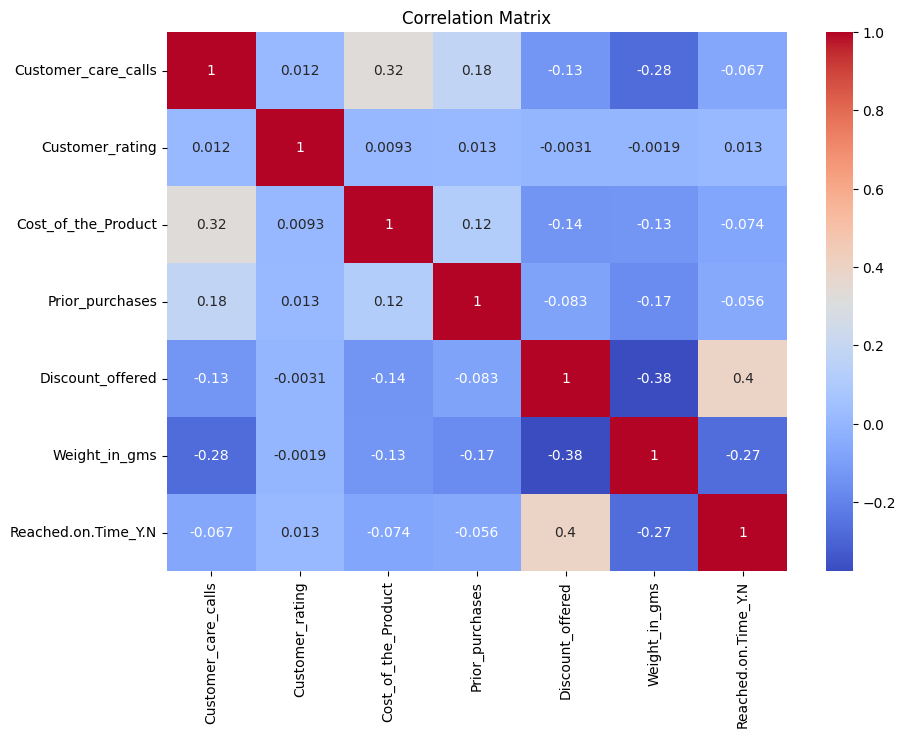

In [ ]:
# Numerical features distribution
numerical_cols = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product',
                  'Prior_purchases', 'Discount_offered', 'Weight_in_gms']
# Correlation heatmap (numerical features + target)
plt.figure(figsize=(10,7))
corr = df[numerical_cols + ['Reached.on.Time_Y.N']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Define target and features

In [ ]:
# Prepare features and target
X = df.drop(['Reached.on.Time_Y.N'], axis=1)
y = df['Reached.on.Time_Y.N']

# Feature Engineering

In [ ]:
# Identify numerical and categorical columns
numerical_cols = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product',
                  'Prior_purchases', 'Discount_offered', 'Weight_in_gms']
categorical_cols = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']

In [ ]:
# Normalize numerical features
scaler = MinMaxScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [ ]:
# Encode categorical columns
for col in X.select_dtypes(include='object').columns:
    X[col] = LabelEncoder().fit_transform(X[col])

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Build a ML Model

# Logistic Regression

In [ ]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [ ]:
print("Logistic Regression Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Results:
Accuracy: 0.64

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.56      0.55      1100
           1       0.70      0.69      0.69      1650

    accuracy                           0.64      2750
   macro avg       0.62      0.62      0.62      2750
weighted avg       0.64      0.64      0.64      2750



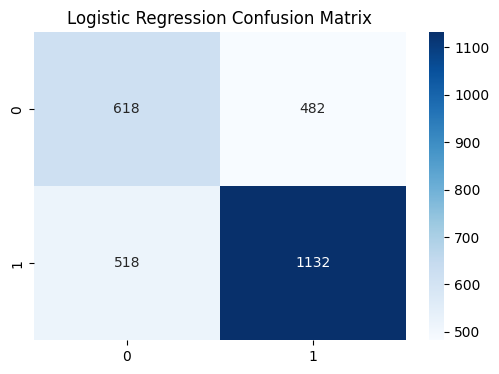

In [ ]:
# Confusion Matrix Visualization
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

# Decision Tree Classifier

In [ ]:
# Decision Tree
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

In [ ]:
print("\nDecision Tree Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))


Decision Tree Results:
Accuracy: 0.67

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.96      0.70      1100
           1       0.94      0.49      0.64      1650

    accuracy                           0.67      2750
   macro avg       0.75      0.72      0.67      2750
weighted avg       0.79      0.67      0.67      2750



# Grid search in Decision tree

In [ ]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 4, 6, 8, 10],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 2, 4]
}

In [ ]:
# Perform Grid Search with cross-validation (e.g., K=5)
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=3, random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 4, 6, 8, 10],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 7]},
             scoring='accuracy')

In [ ]:
# Get the best hyperparameters
best_params = grid_search.best_params_

In [ ]:
# Train a Decision Tree classifier with the best hyperparameters
best_clf = DecisionTreeClassifier(random_state=42, **best_params)
best_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

In [ ]:
# Evaluate the model on the test set
y_pred = best_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

In [ ]:
# Print the best hyperparameters and model accuracy
print(f"Best Hyperparameters: {best_params}")
print(f"Model Accuracy on Test Data: {accuracy:.2f}")

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}
Model Accuracy on Test Data: 0.68


# Random Forest Classifier

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred_rf = rf.predict(X_test)
print("Random Forest Classifier Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Classifier Results:
Accuracy: 0.67
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.72      0.63      1100
           1       0.77      0.63      0.69      1650

    accuracy                           0.67      2750
   macro avg       0.67      0.67      0.66      2750
weighted avg       0.69      0.67      0.67      2750



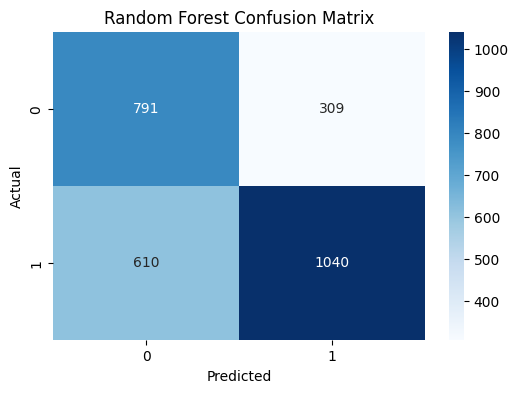

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Grid Search in random forest

In [ ]:
#Parameter grid
param_grid = {
    'max_depth': [4,8,10,12],
    'min_samples_leaf': [2,4,6,8],
    'min_samples_split': [2,4,6,8],
    'criterion': ['gini', 'entropy']
}

In [ ]:
# Perform Grid Search with cross-validation (e.g., K=5)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 8, 10, 12],
                         'min_samples_leaf': [2, 4, 6, 8],
                         'min_samples_split': [2, 4, 6, 8]},
             scoring='accuracy')

In [ ]:
# Get the best hyperparameters
best_params = grid_search.best_params_

In [ ]:
# Train a Random forest classifier with the best hyperparameters
best_rfc = RandomForestClassifier(random_state=42, **best_params)
best_rfc.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=4, min_samples_leaf=2,
                       random_state=42)

In [ ]:
# Evaluate the model on the test set
y_pred = best_rfc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

In [ ]:
# Print the best hyperparameters and model accuracy
print(f"Best Hyperparameters: {best_params}")
print(f"Model Accuracy on Test Data: {accuracy:.2f}")

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2}
Model Accuracy on Test Data: 0.68


# K-Nearest Neighbors(KNN)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
y_pred_knn = knn.predict(X_test)
print("\nK-Nearest Neighbors Classifier Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_knn))


K-Nearest Neighbors Classifier Results:
Accuracy: 0.6545
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.61      0.59      1100
           1       0.72      0.68      0.70      1650

    accuracy                           0.65      2750
   macro avg       0.64      0.65      0.64      2750
weighted avg       0.66      0.65      0.66      2750

